In [ ]:
import numpy as np
import math
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle



pio.renderers.default = "colab"



mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'STIXGeneral'
mpl.rcParams['mathtext.it'] = 'STIXGeneral: italic'
mpl.rcParams['mathtext.bf'] = 'STIXGeneral: bold'



def inter_ins_pol(p, q):
    hamiltBlock = np.zeros((4, 4), dtype = complex)
    theta = ((q - p) * phi + math.pi) % (2 * math.pi) - math.pi

    for i in range(4):
        for j in range(4):
            if i == j:
                if i == 0:
                    hamiltBlock[i][j] = -t_ss_sgm
                elif i == 1 or i == 2:
                    hamiltBlock[i][j] = (1 / 2) * (((-1) ** (i + 1)) * (1 + ((-1) ** i) * math.cos(theta)) * t_pp_sgm + ((-1) ** i) * (1 + ((-1) ** (i + 1)) * math.cos(theta)) * t_pp_p)
                else:
                    hamiltBlock[i][j] = -t_pp_p
            elif i == 0 or j == 0:
                if i == 1 or j == 1:
                    hamiltBlock[i][j] = -math.sin(abs(theta) / 2) * t_sp_sgm
                elif i == 2 or j == 2:
                    hamiltBlock[i][j] = ((1j) ** j) * np.sign(theta) * math.cos(theta / 2) * t_sp_sgm
                else:
                    hamiltBlock[i][j] = 0
            else:
                if (i == 1 and j == 2) or (i == 2 and j == 1):
                    hamiltBlock[i][j] = (1 / 2) * math.sin(((-1) ** j) * theta) * (t_pp_sgm + t_pp_p)
                else:
                    hamiltBlock[i][j] = 0

    return hamiltBlock



def inter_bet_pol(k, m):
    hamiltBlock = np.zeros((4, 4), dtype = complex)
    ind = 1
    for i in range(4):
        for j in range(4):
            if i == j:
                if i == 0:
                    hamiltBlock[i][j] = E_2s - 2 * t_ss_sgm * math.cos(k * b + m * alpha) * ind
                elif i == 1:
                    hamiltBlock[i][j] = E_2p + 2 * (((2 * R * (math.sin(alpha / 2) ** 2) / d) ** 2) * t_pp_sgm - (math.cos(alpha) + (2 * R * (math.sin(alpha / 2) ** 2) / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) * ind
                elif i == 2:
                    hamiltBlock[i][j] = E_2p - 2 * (((R * math.sin(alpha) / d) ** 2) * t_pp_sgm + (math.cos(alpha) - (R * math.sin(alpha) / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) * ind
                else:
                    hamiltBlock[i][j] = E_2p - 2 * (((b / d) ** 2) * t_pp_sgm + (1 - (b / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) * ind
            elif i == 0 or j == 0:
                if i == 1 or j == 1:
                    hamiltBlock[i][j] = -4 * R * (math.sin(alpha / 2) ** 2) / d * t_sp_sgm * math.cos(k * b + m * alpha) * ind
                elif i == 2 or j == 2:
                    hamiltBlock[i][j] = ((-1j) ** (j + 1)) * 2 * R * math.sin(alpha) / d * t_sp_sgm * math.sin(k * b + m * alpha) * ind
                else:
                    hamiltBlock[i][j] = ((-1) ** (j + 1)) * 1j * 2 * b / d * t_sp_sgm * math.sin(k * b + m * alpha) * ind
            else:
                if (i == 1 and j == 2) or (i == 2 and j == 1):
                    hamiltBlock[i][j] = ((-1) ** (j + 1)) * 1j * 2 * math.sin(alpha) * (2 * ((R * math.sin(alpha / 2) / d) ** 2) * t_pp_sgm + (1 - 2 * ((R * math.sin(alpha / 2) / d) ** 2)) * t_pp_p) * math.sin(k * b + m * alpha) * ind
                elif (i == 1 and j == 3) or (i == 3 and j == 1):
                    hamiltBlock[i][j] = -((-1j) ** j) * 4 * R * b * ((math.sin(alpha / 2) / d) ** 2) * (t_pp_sgm - t_pp_p) * math.sin(k * b + m * alpha) * ind
                else:
                    hamiltBlock[i][j] = -2 * R * b * math.sin(alpha) / (d ** 2) * (t_pp_sgm - t_pp_p) * math.cos(k * b + m * alpha) * ind

    return hamiltBlock



def create_hamilt(k, m):
    hamilt = np.zeros([0, 4 * n])

    for i in range(n):
        row = np.empty([4, 0])

        for j in range(n):
            if i == j:
                hamiltBlock = inter_bet_pol(k, m)
            elif abs(i - j) == 1 or abs(i - j) == n - 1:
                hamiltBlock = inter_ins_pol(i, j)
            else:
                hamiltBlock = np.zeros((4, 4))

            row = np.hstack([row, hamiltBlock])

        hamilt = np.concatenate([hamilt, row])

    return hamilt



def hamilt_eig_val(k, m):
    hamilt = create_hamilt(k, m)
    res = np.linalg.eigvals(hamilt).real
    res.sort()
    #print(res)
    return res



def plot_surf(
    x: np.ndarray,
    y: np.ndarray,
    E: np.ndarray,
    bands: list[int],
    elev: float = 45,
    azim: float = 20,
    alpha: float = 0.9,
    figsize: tuple[int, int] = (700, 600),
    title: str = None,
    ):

    colorCycle = cycle(pio.templates["plotly"].layout.colorway)

    X, Y = np.meshgrid(x, y, indexing = "ij")
    fig = go.Figure()

    for band in bands:
        Z = E[:, band].reshape((len(x), len(y)), order = "C")
        c = next(colorCycle)

        fig.add_trace(
            go.Surface(
                x = X, y = Y, z = Z,
                opacity = alpha,
                name = f"band {band}",
                surfacecolor = np.zeros_like(Z),
                colorscale = [[0, c], [1, c]],
                cmin = 0, cmax = 1,
                showscale = False
            )
        )

    fig.update_layout(
        title = title,
        width = figsize[0], height = figsize[1],
        scene = dict(
            xaxis_title = "k",
            yaxis_title = "m",
            zaxis_title = "E",
            camera = dict(
                eye = dict(
                    x = 2 * np.cos(np.radians(azim)) * np.cos(np.radians(elev)),
                    y = 2 * np.sin(np.radians(azim)) * np.cos(np.radians(elev)),
                    z = 2 * np.sin(np.radians(elev))
                    )
                )
        ),
        margin = dict(l = 0, r = 0, b = 0, t = 40)
    )

    fig.show()



def calc_band_gap(E: np.ndarray, bandMin: int, bandMax: int):

    return round(float(E[:, bandMax].min() - E[:, bandMin].max()), 3)



if __name__ == '__main__':
    n = 11
    alphaDeg = 360

    a = 1
    b = 1

    t_ss_sgm = -4.30
    t_sp_sgm = 4.98
    t_pp_sgm = 6.38
    t_pp_p = -2.66

    E_2s = -7.30
    E_2p = 0.00

    alpha = math.pi * alphaDeg / 180
    phi = 2 * math.pi / n
    R = a / (2 * math.sin(phi / 2))
    d = math.sqrt(4 * (R ** 2) * ((math.sin(alpha / 2)) ** 2) + b ** 2)
    #k = -3.73
    #m = 5
    k = np.concatenate((np.linspace(-math.pi / b, 0, 101), np.linspace(0, math.pi / b, 101)[1:]), axis = 0)
    m = np.concatenate((np.linspace(-math.pi / alpha, 0, 101), np.linspace(0, math.pi / alpha, 101)[1:]), axis = 0)

    #coord = calc_coord()
    #res = hamilt_eig_val(k, m)
    res = np.array([hamilt_eig_val(i, j) for i in k for j in m])
    print(f"band_gap = {calc_band_gap(res, 2 * n - 1, 2 * n)} eV")
    plot_surf(k, m, res, bands = [2 * n - 1, 2 * n], alpha = 0.8)

band_gap = 0.558 eV


In [3]:
import numpy as np
import math
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle



pio.renderers.default = "colab"



mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'STIXGeneral'
mpl.rcParams['mathtext.it'] = 'STIXGeneral: italic'
mpl.rcParams['mathtext.bf'] = 'STIXGeneral: bold'



def createHamilt(k, m, l):
    hamilt = np.zeros((4, 4), dtype = complex)

    for i in range(4):
        for j in range(4):
            if i == j:
                if i == 0:
                    hamilt[i][j] = E_2s - 2 * t_ss_sgm * (math.cos(k * b + m * alpha) + math.cos(l * phi))
                elif i == 1:
                    hamilt[i][j] = E_2p + 2 * ((((2 * R * (math.sin(alpha / 2) ** 2) / d) ** 2) * t_pp_sgm - (math.cos(alpha) + (2 * R * (math.sin(alpha / 2) ** 2) / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) + (((2 * R * (math.sin(phi / 2) ** 2) / a) ** 2) * t_pp_sgm - (math.cos(phi) + (2 * R * (math.sin(phi / 2) ** 2) / a) ** 2) * t_pp_p) * math.cos(l * phi))
                elif i == 2:
                    hamilt[i][j] = E_2p - 2 * ((((R * math.sin(alpha) / d) ** 2) * t_pp_sgm + (math.cos(alpha) - (R * math.sin(alpha) / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) + (((R * math.sin(phi) / a) ** 2) * t_pp_sgm + (math.cos(phi) - (R * math.sin(phi) / a) ** 2) * t_pp_p) * math.cos(l * phi))
                else:
                    hamilt[i][j] = E_2p - 2 * ((((b / d) ** 2) * t_pp_sgm + (1 - (b / d) ** 2) * t_pp_p) * math.cos(k * b + m * alpha) + t_pp_p * math.cos(l * phi))
            elif i == 0 or j == 0:
                if i == 1 or j == 1:
                    hamilt[i][j] = -4 * R * ((math.sin(alpha / 2) ** 2) / d * t_sp_sgm * math.cos(k * b + m * alpha) + (math.sin(phi / 2) ** 2) / a * t_sp_sgm * math.cos(l * phi))
                elif i == 2 or j == 2:
                    hamilt[i][j] = ((-1j) ** (j + 1)) * 2 * R * (math.sin(alpha) / d * t_sp_sgm * math.sin(k * b + m * alpha) + math.sin(phi) / a * t_sp_sgm * math.sin(l * phi))
                else:
                    hamilt[i][j] = ((-1) ** (j + 1)) * 1j * 2 * b / d * t_sp_sgm * math.sin(k * b + m * alpha)
            else:
                if (i == 1 and j == 2) or (i == 2 and j == 1):
                    hamilt[i][j] = ((-1) ** (j + 1)) * 1j * 2 * (math.sin(alpha) * (2 * ((R * math.sin(alpha / 2) / d) ** 2) * t_pp_sgm + (1 - 2 * ((R * math.sin(alpha / 2) / d) ** 2)) * t_pp_p) * math.sin(k * b + m * alpha) + math.sin(phi) * (2 * ((R * math.sin(phi / 2) / a) ** 2) * t_pp_sgm + (1 - 2 * ((R * math.sin(phi / 2) / a) ** 2)) * t_pp_p) * math.sin(l * phi))
                elif (i == 1 and j == 3) or (i == 3 and j == 1):
                    hamilt[i][j] = -((-1j) ** j) * 4 * R * b * ((math.sin(alpha / 2) / d) ** 2) * (t_pp_sgm - t_pp_p) * math.sin(k * b + m * alpha)
                else:
                    hamilt[i][j] = -2 * R * b * math.sin(alpha) / (d ** 2) * (t_pp_sgm - t_pp_p) * math.cos(k * b + m * alpha)

    return hamilt



def hamiltEigVals(k, m, l):
    hamilt = createHamilt(k, m, l)
    res = np.linalg.eigvals(hamilt).real
    res.sort()

    return res



def calcBandGap(E: np.ndarray, bandMin: int, bandMax: int):

    return round(float(E[:, bandMax].min() - E[:, bandMin].max()), 3)



# if __name__ == '__main__':
#     n = 4
#     alphaDeg = 18

#     a = 1
#     b = 1

#     t_ss_sgm = -4.30
#     t_sp_sgm = 4.98
#     t_pp_sgm = 6.38
#     t_pp_p = -2.66

#     E_2s = -7.30
#     E_2p = 0.00

#     alpha = math.pi * alphaDeg / 180
#     phi = 2 * math.pi / n
#     R = a / (2 * math.sin(phi / 2))
#     d = math.sqrt(4 * (R ** 2) * ((math.sin(alpha / 2)) ** 2) + b ** 2)

#     k = np.concatenate((np.linspace(-math.pi / b, 0, 101), np.linspace(0, math.pi / b, 101)[1:]), axis = 0)
#     m = np.arange(math.ceil(-math.pi / abs(alpha)), math.floor(math.pi / abs(alpha)) + 1)
#     l = np.arange(math.ceil(-math.pi / phi), math.floor(math.pi / phi) + 1)

#     res = np.array([hamiltEigVals(i, j, q) for i in k for j in m for q in l])
#     print(f"Band Gap = {calcBandGap(res, 1, 2)} eV")

Зависимость band gap vs alpha

In [8]:
import pandas as pd
import numpy as np
import numpy as np
import math
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle
from tqdm import tqdm 

alpha_list = np.arange(9.01, 10.01, 0.1) #! Здесь можно изменить диапазон и шаг для alphaDeg
results = []

n = 4
a = 1
b = 1

t_ss_sgm = -4.30
t_sp_sgm = 4.98
t_pp_sgm = 6.38
t_pp_p = -2.66

E_2s = -7.30
E_2p = 0.00

phi = 2 * math.pi / n
R = a / (2 * math.sin(phi / 2))

k = np.concatenate((np.linspace(-math.pi / b, 0, 101), np.linspace(0, math.pi / b, 101)[1:]), axis = 0)
l = np.arange(math.ceil(-math.pi / phi), math.floor(math.pi / phi) + 1)

for alphaDeg in tqdm(alpha_list, desc="Расчет band gap"):
    alpha = math.pi * alphaDeg / 180
    d = math.sqrt(4 * (R ** 2) * ((math.sin(alpha / 2)) ** 2) + b ** 2)
    m = np.arange(math.ceil(-math.pi / abs(alpha)), math.floor(math.pi / abs(alpha)) + 1)

    res = np.array([hamiltEigVals(i, j, q) for i in k for j in m for q in l])
    band_gap = calcBandGap(res, 1, 2)
    
    results.append({'alphaDeg': round(alphaDeg, 2), 'band_gap': round(band_gap, 5)})
    if len(results) % 100 == 0:
        df = pd.DataFrame(results)
        df.to_csv('band_gap_vs_alpha_backup.csv', index=False)


df = pd.DataFrame(results)
df.to_csv('band_gap_vs_alpha_final.csv', index=False)

Расчет band gap: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


In [10]:
df

alphaDeg  band_gap
0      9.01     1.678
1      9.11     1.664
2      9.21     1.650
3      9.31     1.637
4      9.41     1.623
5      9.51     1.610
6      9.61     1.596
7      9.71     1.583
8      9.81     1.569
9      9.91     1.556

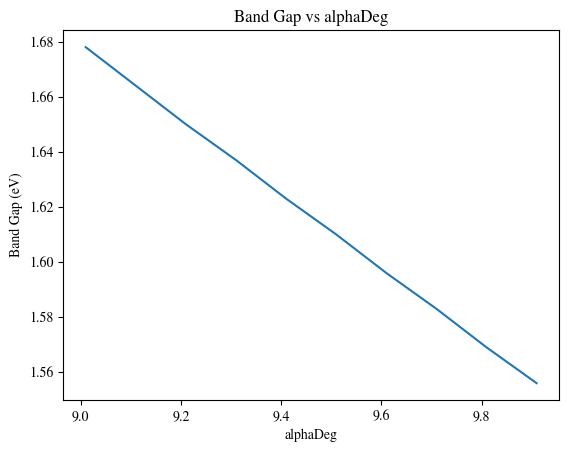

In [9]:
import matplotlib.pyplot as plt

plt.plot(df['alphaDeg'], df['band_gap'])
plt.xlabel('alphaDeg')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs alphaDeg')
plt.show()

In [ ]:
from matplotlib import animation
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl



mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'STIXGeneral'
mpl.rcParams['mathtext.it'] = 'STIXGeneral: italic'
mpl.rcParams['mathtext.bf'] = 'STIXGeneral: bold'



def buildPlot(n, band_gaps, rot_deg_range):
    unit = math.pi
    x_tick = np.array([370, 377.5, 375])
    x_label = [r"$10$", r"$12.5$", r"$15$"]
    fig = plt.figure(figsize = (5, 4))
    ax = fig.add_subplot(111)

    ax.plot(rotAngs, bandGaps, color = 'black', linewidth = 0.5)
    ax.set_xticks(x_tick)
    ax.set_xticklabels(x_label, fontsize = 12)
    ax.set_xlabel(r"$\alpha,$ $deg$", fontsize = 12)
    ax.set_ylabel(r"$BG,$ $eV$", fontsize = 12)
    ax.set_ylim([0, 4])
    ax.set_xlim([360, 350])

    plt.savefig(f"[n; {n}]CPP_band_struct.eps")
    plt.savefig(f"[n; {n}]CPP_band_struct.png")
    plt.show()

gen_plot_1(n, band_gaps, rot_deg_range)

NameError: name 'band_gaps' is not defined